In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
cwd = os.getcwd()

NOTEBOOK_DIR = os.path.dirname(cwd)
ROOT = os.path.dirname(os.path.dirname(os.path.dirname(NOTEBOOK_DIR)))

FIGURES_DIR = os.path.join(ROOT, 'figures/abc_parameterizations/debug_ipllr_renorm')
CONFIG_PATH = os.path.join(ROOT, 'pytorch/configs/abc_parameterizations', 'fc_ipllr_mnist.yaml')

In [3]:
import sys
sys.path.append(ROOT)

In [4]:
import os
from copy import deepcopy
import torch
import math
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from utils.tools import read_yaml, set_random_seeds
from pytorch.configs.base import BaseConfig
from pytorch.configs.model import ModelConfig
from pytorch.models.abc_params.fully_connected.ipllr import FcIPLLR
from pytorch.models.abc_params.fully_connected.muP import FCmuP
from pytorch.models.abc_params.fully_connected.ntk import FCNTK
from pytorch.models.abc_params.fully_connected.standard_fc_ip import StandardFCIP
from utils.data.mnist import load_data
from utils.abc_params.debug_ipllr import *
from utils.plot.abc_parameterizations.debug_ipllr import *

### Load basic configuration and define variables 

In [5]:
N_TRIALS = 5
SEED = 30
L = 6
width = 1024
n_warmup_steps = 1
batch_size = 512
base_lr = 0.01
n_steps = 100
renorm_first = False
scale_first_lr = False

set_random_seeds(SEED)  # set random seed for reproducibility
config_dict = read_yaml(CONFIG_PATH)

In [6]:
config_dict = read_yaml(CONFIG_PATH)

input_size = config_dict['architecture']['input_size']

config_dict['architecture']['width'] = width
config_dict['architecture']['n_layers'] = L + 1
config_dict['optimizer']['params']['lr'] = base_lr
config_dict['scheduler'] = {'name': 'warmup_switch',
                            'params': {'n_warmup_steps': n_warmup_steps,
                                       'calibrate_base_lr': True,
                                       'default_calibration': False}}
        
base_model_config = ModelConfig(config_dict)

### Load data & define models

In [7]:
training_dataset, test_dataset = load_data(download=False, flatten=True)
train_data_loader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
test_batches = list(DataLoader(test_dataset, shuffle=False, batch_size=batch_size))
batches = list(train_data_loader)
eval_batch = test_batches[0]

In [8]:
config_dict['scheduler']['params']['calibrate_base_lr'] = False
config = ModelConfig(config_dict)

ipllrs = [FcIPLLR(config) for _ in range(N_TRIALS)]
#ipllrs_renorm = [FcIPLLR(config) for _ in range(N_TRIALS)]
#ipllrs_renorm_scale_lr = [FcIPLLR(config) for _ in range(N_TRIALS)]

config_dict['scheduler']['params']['calibrate_base_lr'] = True
config = ModelConfig(config_dict)
ipllrs_calib = [FcIPLLR(config, lr_calibration_batches=batches) for _ in range(N_TRIALS)]
ipllrs_calib_renorm = [FcIPLLR(config, lr_calibration_batches=batches) for _ in range(N_TRIALS)]
ipllrs_calib_renorm_scale_lr = [FcIPLLR(config, lr_calibration_batches=batches) for _ in range(N_TRIALS)]

initial base lr : [7.8500000000000005, 50.600318908691406, 70.35978698730469, 68.40836334228516, 74.03289031982422, 102.55811309814453, 3.098381280899048]
initial base lr : [7.8500000000000005, 51.106361389160156, 68.59902954101562, 72.93223571777344, 78.6222915649414, 90.54884338378906, 2.9079697132110596]
initial base lr : [7.8500000000000005, 49.130645751953125, 60.061195373535156, 65.48074340820312, 75.3825912475586, 83.77481842041016, 2.2768843173980713]
initial base lr : [7.8500000000000005, 55.35302734375, 73.82594299316406, 76.13689422607422, 83.21652221679688, 115.44131469726562, 3.531343698501587]
initial base lr : [7.8500000000000005, 53.060760498046875, 73.16078186035156, 69.70211029052734, 77.32321166992188, 93.46554565429688, 2.64848256111145]
initial base lr : [7.8500000000000005, 46.9710578918457, 72.5624008178711, 70.770263671875, 75.82337951660156, 87.43965148925781, 2.8482162952423096]
initial base lr : [7.8500000000000005, 48.167484283447266, 61.27650451660156, 63.8

In [9]:
for i in range(N_TRIALS):
    # copy params
    #ipllrs_renorm[i].copy_initial_params_from_model(ipllrs[i])
    #ipllrs_renorm_scale_lr[i].copy_initial_params_from_model(ipllrs[i])
    
    ipllrs_calib[i].copy_initial_params_from_model(ipllrs[i])
    ipllrs_calib_renorm[i].copy_initial_params_from_model(ipllrs[i])
    ipllrs_calib_renorm_scale_lr[i].copy_initial_params_from_model(ipllrs[i])
    
    # re-initialize
    #ipllrs_renorm[i].initialize_params()
    #ipllrs_renorm_scale_lr[i].initialize_params()
    
    ipllrs_calib[i].initialize_params()
    ipllrs_calib_renorm[i].initialize_params()
    ipllrs_calib_renorm_scale_lr[i].initialize_params()

In [10]:
# Make sure calibration takes into account normalization

for ipllr in ipllrs_calib:    
    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=False)
    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)
    
for ipllr in ipllrs_calib_renorm:        
    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=True)
    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)
    
for ipllr in ipllrs_calib_renorm_scale_lr:            
    initial_base_lrs = ipllr.scheduler.calibrate_base_lr(ipllr, batches=batches, normalize_first=True)
    ipllr.scheduler._set_param_group_lrs(initial_base_lrs)

initial base lr : [0.01, 0.06005667522549629, 1.2277015447616577, 2.1790976524353027, 2.4939730167388916, 2.87255859375, 0.08645337074995041]
initial base lr : [0.01, 0.05959025025367737, 1.2829102277755737, 2.54594087600708, 2.795259714126587, 3.3299622535705566, 0.10341224074363708]
initial base lr : [0.01, 0.05906084179878235, 1.2531068325042725, 2.452989339828491, 2.6011409759521484, 3.096604824066162, 0.0884433165192604]
initial base lr : [0.01, 0.06040874868631363, 1.29351007938385, 2.221619129180908, 2.727776288986206, 3.3855526447296143, 0.09613928943872452]
initial base lr : [0.01, 0.06201217323541641, 1.1933470964431763, 2.331674814224243, 2.296248435974121, 2.62015438079834, 0.07345645874738693]
initial base lr : [7.8500000000000005, 46.98689651489258, 62.042476654052734, 61.632041931152344, 69.83226013183594, 80.47383880615234, 2.422163486480713]
initial base lr : [7.8500000000000005, 46.830177307128906, 68.40361785888672, 72.4375, 78.34947967529297, 93.29377746582031, 2.89

In [11]:
# scale lr of first layer if needed

#for ipllr in ipllrs_renorm_scale_lr:
#    for i, param_group in enumerate(ipllr.optimizer.param_groups):
#        if i == 0:
#            param_group['lr'] = param_group['lr'] * (ipllr.d + 1)
#    ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)
    
for ipllr in ipllrs_calib_renorm_scale_lr:
    ipllr.scheduler.warm_lrs[0] = ipllr.scheduler.warm_lrs[0] * (ipllr.d + 1)

In [12]:
results = dict()

# without calibration
#results['ipllr'] = [collect_training_losses(ipllrs[i], batches, n_steps, normalize_first=False) 
#                    for i in range(N_TRIALS)]

#results['ipllr_renorm'] = [collect_training_losses(ipllrs_renorm[i], batches, n_steps, normalize_first=True)
#                           for i in range(N_TRIALS)]

#results['ipllr_renorm_scale_lr'] = [collect_training_losses(ipllrs_renorm_scale_lr[i], batches, n_steps, 
#                                                            normalize_first=True) 
#                                    for i in range(N_TRIALS)]

# with calibration
results['ipllr_calib'] = [collect_training_losses(ipllrs_calib[i], batches, n_steps, normalize_first=False)
                                 for i in range(N_TRIALS)]

results['ipllr_calib_renorm'] = [collect_training_losses(ipllrs_calib_renorm[i], batches, n_steps, 
                                                         normalize_first=True)
                                 for i in range(N_TRIALS)]

results['ipllr_calib_renorm_scale_lr'] = \
    [collect_training_losses(ipllrs_calib_renorm_scale_lr[i], batches, n_steps, normalize_first=True) 
     for i in range(N_TRIALS)]

# Training

In [13]:
mode = 'training'

In [14]:
losses = dict()
for key, res in results.items():
    losses[key] = [r[0] for r in res]
    
chis = dict()
for key, res in results.items():
    chis[key] = [r[1] for r in res]

## Losses and derivatives

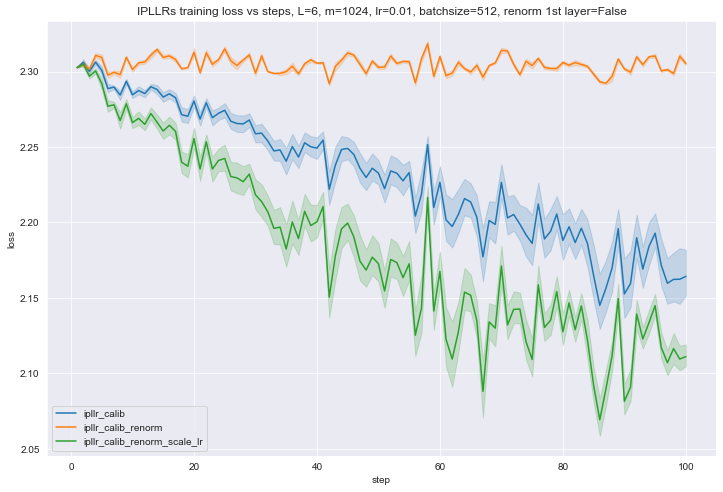

In [15]:
key = 'loss'
plt.figure(figsize=(12, 8))
plot_losses_models(losses, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, 
                   normalize_first=renorm_first, marker=None, name='IPLLR')
plt.savefig(
    os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
                 format(mode, key, L, width, base_lr, batch_size, renorm_first, scale_first_lr)))
plt.show()

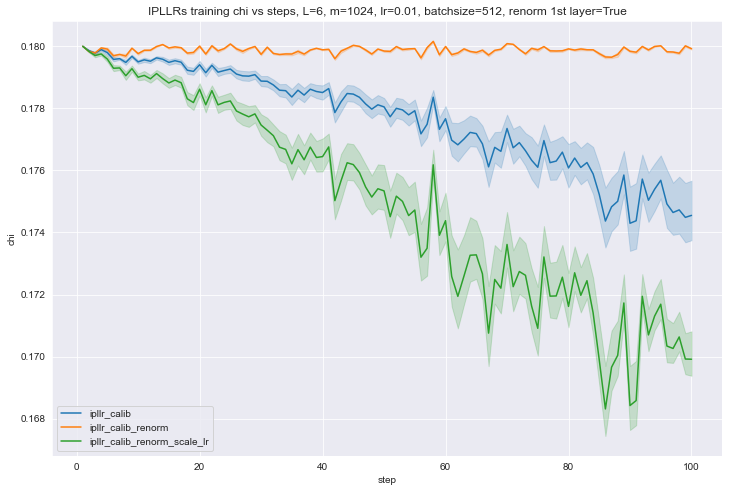

In [16]:
key = 'chi'
plt.figure(figsize=(12, 8))
plot_losses_models(chis, key=key, L=L, width=width, lr=base_lr, batch_size=batch_size, mode=mode, marker=None,
                   name='IPLLR')
plt.savefig(os.path.join(FIGURES_DIR, 'IPLLRs_1_last_small_{}_{}_L={}_m={}_lr={}_bs={}.png'.\
                         format(mode, key, L, width, base_lr, batch_size)))
plt.show()